In [1]:
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

### Global Imports

In [2]:
import os
import datetime
import errno
import argparse

import numpy as np
import tensorflow as tf

from tensorflow.python.keras import backend as K
from tensorflow.python.keras.optimizers import SGD, Adam
from tensorflow.python.keras.models import Sequential, Model

from deepcell import get_data
from deepcell import make_training_data
from deepcell import rate_scheduler
from deepcell.model_zoo import siamese_model
from deepcell.training import train_model_siamese_daughter

Using TensorFlow backend.


### Training the Model

In [3]:
from deepcell import rate_scheduler
from deepcell.model_zoo import siamese_model
from deepcell.training import train_model_siamese_daughter

#direc_data = '/data/npz_data/cells/HeLa/S3/movie/'
#dataset = 'nuclear_movie_hela0-7_same'

direc_data = '/data/npz_data/cells/3T3/NIH/movie/'
dataset = 'nuclear_movie_3T3_and_HeLa'

optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
lr_sched = rate_scheduler(lr=0.01, decay=0.99)
in_shape = (32, 32, 1)
features = {"appearance", "distance", "neighborhood", "regionprop"}

model = siamese_model(input_shape=in_shape, features=features, neighborhood_scale_size=30)

tracking_model = train_model_siamese_daughter(model=model,
                                              dataset=dataset,
                                              optimizer=optimizer,
                                              expt='trks',
                                              it=0,
                                              batch_size=128,
                                              min_track_length=6,
                                              features=features,
                                              neighborhood_scale_size=30,
                                              n_epoch=5,
                                              direc_save='/data/models/cells/3T3/NIH',
                                              direc_data=direc_data,
                                              lr_sched=lr_sched,
                                              rotation_range=180,
                                              flip=True,
                                              shear=0,
                                              class_weight=None,
                                              seed=12345)

training on dataset:  /data/npz_data/cells/3T3/NIH/movie/nuclear_movie_3T3_and_HeLa.trks
saving model at: /data/models/cells/3T3/NIH/2018-12-03_nuclear_movie_3T3_and_HeLa_[a,d,n,r]_neighs=30_epochs=5_seed=12345_trks_0.h5
saving loss at: /data/models/cells/3T3/NIH/2018-12-03_nuclear_movie_3T3_and_HeLa_[a,d,n,r]_neighs=30_epochs=5_seed=12345_trks_0.npz
X_train shape: (242, 40, 216, 256, 1)
y_train shape: (242, 40, 216, 256, 1)
X_test shape: (27, 40, 216, 256, 1)
y_test shape: (27, 40, 216, 256, 1)
Output Shape: (None, 3)
Using real-time data augmentation.
total_train_pairs: 1580240
total_test_pairs: 205920
batch size:  128
validation_steps:  1608
Epoch 1/5
12344/12345 [============================>.] - ETA: 0s - loss: 0.0311 - acc: 0.9929
Epoch 00001: val_loss improved from inf to 0.35286, saving model to /data/models/cells/3T3/NIH/2018-12-03_nuclear_movie_3T3_and_HeLa_[a,d,n,r]_neighs=30_epochs=5_seed=12345_trks_0.h5
12345/12345 [==============================] - 6213s 503ms/step - loss

### Data Review

In [ ]:
data = np.load('/data/npz_data/cells/HeLa/S3/movie/nuclear_movie_hela0-7_same.npz')
#data = np.load('/data/npz_data/cells/HeLa/S3/movie/nuclear_movie_HeLa_0_same.npz')
data.keys()
data_readable_X, data_readable_y = data['X'][()], data['y'][()]
print('X Shape:', data_readable_X.shape)
print('y Shape:', data_readable_y.shape)

In [ ]:
import matplotlib.pyplot as plt
from skimage.io import imshow

img_raw = data_readable_X[0,0,:,:,0]
img_ann = data_readable_y[0,0,:,:,0]

# Visualize the result 
fig, ax = plt.subplots(1, 2, figsize=(12,12))
ax[0].imshow(img_raw, interpolation='none', cmap='gray')
ax[1].imshow(img_ann, interpolation='none', cmap='gray')
ax[0].set_title('Contrast (or Raw) Images')
ax[1].set_title('Annotated Images')
plt.show()

In [ ]:
train_dict, val_dict = get_data('/data/npz_data/cells/3T3/NIH/movie/nuclear_movie_3T3_and_HeLa.trks',
                                        mode='siamese_daughters', seed=12345)

In [ ]:
for batch in range(train_dict["y"].shape[0]):
    X = train_dict["X"][batch]
    y = train_dict["y"][batch]
    d = train_dict["daughters"][batch]
    unique = {*map(int, np.unique(y))}
    unique.remove(0)
    keys = {*d.keys()}
    if keys != unique:
        print(batch)

In [ ]:
train_dict["y"].shape

In [ ]:
import matplotlib.pyplot as plt
from skimage.io import imshow

# Compare 2 images
img_1 = train_dict['X'][0,1,:,:,0]
img_2 = train_dict['y'][0,1,:,:,0]

fig, ax = plt.subplots(1, 2, figsize=(12,12))
ax[0].imshow(img_1, interpolation='none', cmap='gray')
ax[1].imshow(img_2, interpolation='none', cmap='gray')
plt.show()

### Verifying Model Accuracy with Confusion Matrix

In [24]:
train_dict, val_dict = get_data('/data/npz_data/cells/3T3/NIH/movie/nuclear_movie_3T3_and_HeLa.trks',
                                        mode='siamese_daughters', seed=12345)

In [29]:
import deepcell.image_generators as generators

datagen_val = generators.SiameseDataGenerator(
        rotation_range=0,  # randomly rotate images by 0 to rotation_range degrees
        shear_range=0,  # randomly shear images in the range (radians , -shear_range to shear_range)
        horizontal_flip=0,  # randomly flip images
        vertical_flip=0)  # randomly flip images

val_iterator = generators.SiameseIterator(val_dict,
                                          datagen_val,
                                          neighborhood_scale_size=30,
                                          crop_dim=32,
                                          min_track_length=5,
                                          features={"appearance", "distance", "neighborhood", "regionprop"})

In [30]:
from sklearn.metrics import confusion_matrix

Y = []
Y_pred = []
for i in range(1,1001):
    if i % 100 == 0:
        print(".", end="")
    lst, y_true = next(val_iterator)
    y_true = list(map(np.argmax, y_true))
    y_pred = list(map(np.argmax, tracking_model.predict(lst)))
    Y.extend(y_true)
    Y_pred.extend(y_pred)

confusion_matrix(Y, Y_pred)

..........

array([[9858,   15,   25],
       [  22, 9874,   33],
       [ 740, 1278, 7824]])

In [31]:
sum(np.array(Y) == np.array(Y_pred)) / len(Y)

0.9287808824025077

### Tracking Test

In [4]:
# Load up data to test
train_dict, val_dict = get_data('/data/npz_data/cells/3T3/NIH/movie/nuclear_movie_3T3_and_HeLa.trks',
                                        mode='siamese_daughters', seed=12345)

In [5]:
from deepcell.model_zoo import siamese_model

# Import the tracking model
MODEL_DIR = '/data/models/'
PREFIX = 'cells/3T3/NIH/'
in_shape = (32, 32, 1)
features = {"appearance", "neighborhood", "distance", "regionprop"}

# Now we need to re-instantiate the model and load weights
siamese_weights_file = '2018-12-03_nuclear_movie_3T3_and_HeLa_[a,d,n,r]_neighs=30_epochs=5_seed=12345_trks_0.h5'
siamese_weights_file = os.path.join(MODEL_DIR, PREFIX, siamese_weights_file)

tracking_model = siamese_model(input_shape=in_shape, neighborhood_scale_size=30, features=features)
tracking_model.load_weights(siamese_weights_file)

In [22]:
import importlib
import deepcell.tracking
importlib.reload(deepcell.tracking)

batch = 0
trial = deepcell.tracking.cell_tracker(train_dict['X'][batch], train_dict['y'][batch],
#trial = deepcell.tracking.cell_tracker(test_data['X'][0], test_data['y'][0],
                     tracking_model,
                     max_distance=200,
                     track_length=5, division=0.5, birth=0.9, death=0.9,
                     neighborhood_scale_size=30,
                     features=features)
trial._track_cells()

Tracking frame 1
cells in frame [1012 1013 1014 1015 1016 1017 1018 1019 1020 1021 1022 1023]
Tracking frame 2
cells in frame [1024 1025 1026 1027 1028 1029 1030 1031 1032 1033 1034]
Tracking frame 3
cells in frame [1035 1036 1037 1038 1039 1040 1041 1042 1043 1044]
Tracking frame 4
cells in frame [1045 1046 1047 1048 1049 1050 1051 1052 1053 1054]
Tracking frame 5
cells in frame [1055 1056 1057 1058 1059 1060 1061 1062 1063 1064]
Tracking frame 6
cells in frame [1065 1066 1067 1068 1069 1070 1071 1072 1073 1074]
Tracking frame 7
cells in frame [1075 1076 1077 1078 1079 1080 1081 1082 1083 1084 1085]
New track
Division detected
appearances removed from track  3
frames in the track  [0, 1, 2, 3, 4, 5, 6, 7]
length of daughter track  1
daughters  [12]
new track id  13
label  4
frame being removed  7
Tracking frame 8
cells in frame [1086 1087 1088 1089 1090 1091 1092 1093 1094 1095 1096 1097]
Tracking frame 9
cells in frame [1098 1099 1100 1101 1102 1103 1104 1105 1106 1107 1108 1109 1110

/usr/local/lib/python3.5/dist-packages/deepcell/tracking.py:640: RuntimeWarning: invalid value encountered in true_divide
  X_reduced /= np.amax(X_reduced)


cells in frame [1375 1376 1377 1378 1379 1380 1381 1382 1383 1384 1385 1386 1387 1388]
Tracking frame 30
cells in frame []
Tracking frame 31
cells in frame []
Tracking frame 32
cells in frame []
Tracking frame 33
cells in frame []
Tracking frame 34
cells in frame []
Tracking frame 35
cells in frame []
Tracking frame 36
cells in frame []
Tracking frame 37
cells in frame []
Tracking frame 38
cells in frame []
Tracking frame 39
cells in frame []


## Visualizing the Result

In [34]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

def get_js_video(images, batch=0, channel=0):
    fig = plt.figure()    
    ims = []
    for i in range(images.shape[1]):
        im = plt.imshow(images[batch, i, :, :, channel], animated=True, cmap='cubehelix', vmin=0, vmax=1700)
        ims.append([im])
        ani = animation.ArtistAnimation(fig, ims, interval=75, repeat_delay=1000)
#         plt.close()
    return HTML(ani.to_jshtml())

In [ ]:
# print("track ids:", len(trial.tracks))
# trial.tracks[0]['frames']
# The labels are all advanced on

for key, track in trial.tracks.items():
    print(key, track['daughters'], track['frames'])

In [ ]:
for i in range(40):
    print(i, np.unique(trial.y_tracked[i]))
    
# np.sum(trial.y_tracked[29] == 8)

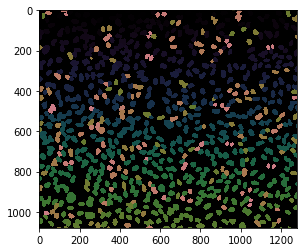

In [35]:
get_js_video(np.expand_dims(trial.y_tracked, axis=0))

In [ ]:
#get_js_video(test_data['y'])
get_js_video(train_dict['y'], batch=batch)
#get_js_video(train_dict['y'], batch=1)

## Save the Raw and Tracked Output

In [ ]:
channel = 0

for i in range(45):
    #name_raw = os.paHeLa_and_3T3th.join('tracking_movies/test_true2_{:02}_.png'.format(i))
    name_tracked = os.path.join('tracking_movies/test_tracked3_{:02}_.png'.format(i))
    #plt.imsave(name_raw, test_data['y'][0, i, :, :, channel], cmap='jet')
    plt.imsave(name_tracked, trial.y_tracked[i, :, :, channel], cmap='cubehelix', vmin=0, vmax=250)


In [ ]:
print(trial.y_tracked.shape)

In [ ]:
print([key for key in trial.tracks.keys()])
print([trial.tracks[key]['label'] for key in trial.tracks.keys()])
print([trial.tracks[key]['parent'] for key in trial.tracks.keys()])
print([trial.tracks[key]['daughters'] for key in trial.tracks.keys()])
print([trial.tracks[key]['capped'] for key in trial.tracks.keys()])
print(trial.tracks[0]['frames'])
print(trial.tracks[5]['frames'])
print(trial.tracks[6]['frames'])
print(trial.tracks[7]['frames'])

In [ ]:
BASE_DIR = '/data/cells/'
cell_type = 'HeLa/S3'
cell_set = 0
montage

filename = '2018-11-04_nuclear_movie_hela0-7_same_[a,d,n,r]_og=20_epochs=5_normalized_0.h5'
other_filename = os.path.join(MODEL_DIR, PREFIX, siamese_weights_file)

In [ ]:
from sklearn.metrics import confusion_matrix
from IPython.display import clear_output
import time

datagen_val = SiameseDataGenerator(
    rotation_range=180,  # randomly rotate images by 0 to rotation_range degrees
    shear_range=0,  # randomly shear images in the range (radians , -shear_range to shear_range)
    horizontal_flip=0,  # randomly flip images
    vertical_flip=0)  # randomly flip images

batch_size=128
min_track_length=5
# fit the model on the batches generated by datagen.flow()
test = datagen_val.flow(train_dict, batch_size=batch_size, min_track_length=min_track_length, shuffle=False)

cm = np.zeros((3,3))
N_div = 0.
N_tot = 0.

for batch_x, batch_y in test:
    clear_output(wait=True)
    
    y_pred = tracking_model.predict(batch_x)
    
    truth = np.argmax(batch_y, axis=-1)
    pred = np.argmax(y_pred, axis=-1)
    cm_temp = confusion_matrix(truth,pred)
    if cm_temp.shape[0] == 2:
        cm[0:2,0:2] += cm_temp
    else:
        cm += confusion_matrix(truth,pred)
        
    N_div += np.sum(truth == 2)
    N_tot += truth.shape[0]
    
    print(np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2), N_div/N_tot)

    
# y_true = test.classes
# y_pred = tracking_model.predict_generator(test)
# print(y_pred)
# Y_test = np.argmax(y_test, axis=1) # Convert one-hot to index
# y_pred = model.predict_classes(x_test)
# print(classification_report(y_true, np.argmax(y_pred, axis=-1)))

## Generating CSV

In [ ]:
from deepcell.model_zoo import siamese_model

train_dict, val_dict = get_data('/data/npz_data/cells/3T3/NIH/movie/nuclear_movie_3T3_and_HeLa.npz',
                                mode='siamese_daughters')

# Now we need to re-instantiate the model and load weights
directory = '/data/models/cells/3T3/NIH'
in_shape = (32, 32, 1)
features = {"appearance", "neighborhood", "distance", "regionprop"}
siamese_weights_file = '2018-11-15_nuclear_movie_3T3_and_HeLa_[a,d,n,r]_og=40_epochs=5_seed=777_multicell_0.h5'
siamese_weights_file = os.path.join(directory, siamese_weights_file)
tracking_model = siamese_model(input_shape=in_shape, occupancy_grid_size=40, features=features)
tracking_model.load_weights(siamese_weights_file)

In [ ]:
import importlib
import deepcell.tracking
importlib.reload(deepcell.tracking)

batch = 7
trial = deepcell.tracking.cell_tracker(train_dict['X'][batch], train_dict['y'][batch],
                     tracking_model,
                     max_distance=200,
                     track_length=5, division=0.5, birth=0.9, death=0.9,
                     neighborhood_scale_size=40,
                     features=features)
trial._track_cells()

In [ ]:
trial.dataframe()

In [23]:
trial.dump("dumps/3t3-hela_s12345b10.trk")

## Track Multiple Movies and Generate Track Files

In [20]:
import numpy as np
from deepcell.model_zoo import siamese_model

# Define source data
data = np.load('/data/data/cells/HEK293/generic/set0/deepcell_segmentations_v1/nuclear_movie_HEK293_set0_large.npz')
data.keys()
data_readable_X, data_readable_y = data['X'][()], data['y'][()]
print('X Shape:', data_readable_X.shape)
print('y Shape:', data_readable_y.shape)

X Shape: (1, 71, 1080, 1280, 1)
y Shape: (1, 71, 1080, 1280, 1)


In [ ]:
# Check data if needed
import matplotlib.pyplot as plt
from skimage.io import imshow

img_raw = data_readable_X[0,0,:,:,0]
img_ann = data_readable_y[0,0,:,:,0]

# Visualize the result 
fig, ax = plt.subplots(1, 2, figsize=(12,12))
ax[0].imshow(img_raw, interpolation='none', cmap='gray')
ax[1].imshow(img_ann, interpolation='none', cmap='gray')
ax[0].set_title('Raw image batch 0 frame 0')
ax[1].set_title('Annotated Image')
plt.show()

In [ ]:
# Normalize raw if needed
def image_norm(original_image):
    # NNs prefer input data that is 0 mean and unit variance
    normed_image = (original_image - np.mean(original_image)) / np.std(original_image)
    return normed_image

for batch in range(data_readable_X.shape[0]):
    for frame in range(data_readable_X.shape[1]):
        data_readable_X[batch, frame, :, :, 0] = image_norm(data_readable_X[batch, frame, :, :, 0]) 

In [4]:
import os
import deepcell.tracking

# Now we need to re-instantiate the model and load weights
directory = '/data/models/cells/3T3/NIH'
in_shape = (32, 32, 1)
features = {"appearance", "neighborhood", "distance", "regionprop"}
siamese_weights_file = '2018-12-04_nuclear_movie_3T3_and_HeLa_[a,d,n,r]_neighs=30_epochs=5_seed=666_trks_0.h5'
siamese_weights_file = os.path.join(directory, siamese_weights_file)
tracking_model = siamese_model(input_shape=in_shape, neighborhood_scale_size=30, features=features)
tracking_model.load_weights(siamese_weights_file)

In [ ]:
base_path = "/data/data/cells/3T3/NIH/set0/deepcell_segmentations_v1/part_2/tracks/"
base_name = "3T3_S0P2_Batch"

for batch in range (data['X'].shape[0]):
    trial = deepcell.tracking.cell_tracker(data['X'][batch], data['y'][batch],
                         tracking_model,
                         max_distance=200,
                         track_length=5, division=0.5, birth=0.9, death=0.9,
                         neighborhood_scale_size=30,
                         features=features)
    trial._track_cells()
    file_name = base_name + str(batch).zfill(2) + '.trk'
    file_path = os.path.join(base_path, file_name)
    trial.dump(file_path)

/usr/local/lib/python3.5/dist-packages/skimage/measure/_regionprops.py:250: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See http://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)
/usr/local/lib/python3.5/dist-packages/skimage/measure/_regionprops.py:260: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See http://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)
/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabl

Tracking frame 1
cells in frame [1010 1011 1012 1013 1014 1015 1016 1017 1018 1019]
Tracking frame 2
cells in frame [1020 1021 1022 1023 1024 1025 1026 1027 1028 1029]
Tracking frame 3
cells in frame [1030 1031 1032 1033 1034 1035 1036 1037 1038 1039]
Tracking frame 4
cells in frame [1040 1041 1042 1043 1044 1045 1046 1047 1048 1049]
Tracking frame 5
cells in frame [1050 1051 1052 1053 1054 1055 1056 1057 1058 1059]
Tracking frame 6
cells in frame [1060 1061 1062 1063 1064 1065 1066 1067 1068 1069 1070]
New track
Division detected
appearances removed from track  0
frames in the track  [0, 1, 2, 3, 4, 5, 6]
length of daughter track  1
daughters  [10]
new track id  11
label  1
frame being removed  6
Tracking frame 7
cells in frame [1071 1072 1073 1074 1075 1076 1077 1078 1079 1080 1081 1082]
New track
Division detected
New track
Division detected
Tracking frame 8
cells in frame [1083 1084 1085 1086 1087 1088 1089 1090 1091 1092 1093 1094]
Tracking frame 9
cells in frame [1095 1096 1097 1

cells in frame [1318 1319 1320 1321 1322 1323 1324 1325 1326 1327 1328 1329]
Tracking frame 26
cells in frame [1330 1331 1332 1333 1334 1335 1336 1337 1338 1339 1340 1341]
Tracking frame 27
cells in frame [1342 1343 1344 1345 1346 1347 1348 1349 1350 1351 1352 1353]
Tracking frame 28
cells in frame [1354 1355 1356 1357 1358 1359 1360 1361 1362 1363 1364 1365]
Tracking frame 29
cells in frame [1366 1367 1368 1369 1370 1371 1372 1373 1374 1375 1376 1377]
Tracking frame 1
cells in frame [1015 1016 1017 1018 1019 1020 1021 1022 1023 1024 1025 1026 1027 1028
 1029]
Tracking frame 2
cells in frame [1030 1031 1032 1033 1034 1035 1036 1037 1038 1039 1040 1041 1042 1043
 1044]
Tracking frame 3
cells in frame [1045 1046 1047 1048 1049 1050 1051 1052 1053 1054 1055 1056 1057 1058]
Tracking frame 4
cells in frame [1059 1060 1061 1062 1063 1064 1065 1066 1067 1068 1069 1070 1071 1072]
Tracking frame 5
cells in frame [1073 1074 1075 1076 1077 1078 1079 1080 1081 1082 1083 1084 1085 1086]
Tracking fr

cells in frame [1094 1095 1096 1097 1098 1099 1100 1101 1102 1103 1104 1105 1106]
Tracking frame 9
cells in frame [1107 1108 1109 1110 1111 1112 1113 1114 1115 1116 1117 1118 1119]
Tracking frame 10
cells in frame [1120 1121 1122 1123 1124 1125 1126 1127 1128 1129 1130 1131 1132]
Tracking frame 11
cells in frame [1133 1134 1135 1136 1137 1138 1139 1140 1141 1142 1143 1144 1145 1146]
New track
Tracking frame 12
cells in frame [1147 1148 1149 1150 1151 1152 1153 1154 1155 1156 1157 1158 1159 1160]
New track
Tracking frame 13
cells in frame [1161 1162 1163 1164 1165 1166 1167 1168 1169 1170 1171 1172 1173]
Tracking frame 14
cells in frame [1174 1175 1176 1177 1178 1179 1180 1181 1182 1183 1184 1185 1186]
Tracking frame 15
cells in frame [1187 1188 1189 1190 1191 1192 1193 1194 1195 1196 1197 1198 1199 1200]
Tracking frame 16
cells in frame [1201 1202 1203 1204 1205 1206 1207 1208 1209 1210 1211 1212 1213 1214]
Tracking frame 17
cells in frame [1215 1216 1217 1218 1219 1220 1221 1222 1223 

In [ ]:
base_path = "/data/data/cells/3T3/NIH/set0/deepcell_segmentations_v1/part_2/tracks/"
base_name = "3T3_S0P2_Batch"

batch = 0
trial = deepcell.tracking.cell_tracker(data['X'][batch][0:30], data['y'][batch][0:30],
                     tracking_model,
                     max_distance=200,
                     track_length=5, division=0.5, birth=0.9, death=0.9,
                     neighborhood_scale_size=30,
                     features=features)
trial._track_cells()



/usr/local/lib/python3.5/dist-packages/skimage/measure/_regionprops.py:250: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See http://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)
/usr/local/lib/python3.5/dist-packages/skimage/measure/_regionprops.py:260: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See http://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)
/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabl

Tracking frame 1


In [36]:
channel = 0

for i in range(30):
    #name_raw = os.path.join('tracking_movies/3T3_S0P2_batch3_{:02}_.png'.format(i))
    name_tracked = os.path.join('tracking_movies/HEK293_set0_large_{:02}_.png'.format(i))
    #plt.imsave(name_raw, test_data['y'][0, i, :, :, channel], cmap='jet')
    plt.imsave(name_tracked, trial.y_tracked[i, :, :, channel], cmap='cubehelix', vmin=0, vmax=1700)
